<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Interpretability:-multi-spectral-dataset-(11-years)" data-toc-modified-id="Interpretability:-multi-spectral-dataset-(11-years)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Interpretability: multi-spectral dataset (11 years)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Un-filtered-data" data-toc-modified-id="Un-filtered-data-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Un-filtered data</a></span></li><li><span><a href="#Filtered-data" data-toc-modified-id="Filtered-data-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Filtered data</a></span></li></ul></li></ul></li><li><span><a href="#Climatic-dataset-(3-years)" data-toc-modified-id="Climatic-dataset-(3-years)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Climatic dataset (3 years)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#3-hourly" data-toc-modified-id="3-hourly-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>3-hourly</a></span></li><li><span><a href="#daily-averages" data-toc-modified-id="daily-averages-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>daily averages</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import sys
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from tqdm import tqdm
import pandas as pd
import seaborn as sns

import utils_crops
import esig.tosig as esig

import RBF_RBF
import kerES
import linSES
import sklearn_transformers

import iisignature
from sklearn.linear_model import LassoCV

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Interpretability: multi-spectral dataset (11 years)

In [3]:
targets_dico = pickle.load(open('../data/labels_ndvi_dico.obj', 'rb'))
y = list(targets_dico.values())

### Un-filtered data

In [4]:
X = pickle.load(open('../data/bags_ndvi.obj','rb'))

### Filtered data

In [5]:
X_filter, target_dico_filter = utils_crops.filter_ndvi_data(X,targets_dico)
y_filter = list(target_dico_filter.values())

In [6]:
ll = None
at = False
depth1 = 2
depth2 = 2

X_sigEsig = []
    
# take sigEsig feature map
for bag in tqdm(X_filter):
    intermediate = []
    for path in bag:
        if ll is not None:
            path = LeadLag(ll).fit_transform([path])[0]
        if at:
            path = AddTime().fit_transform([path])[0]
        sig_path = iisignature.sig(path, depth1, 2) 
        intermediate.append(sig_path)

    try:
        intermediate = iisignature.sig(intermediate, depth2)
    except:
        intermediate_intermediate = []
        for p in intermediate:
            try:
                intermediate_intermediate.append(iisignature.sig(p, depth2))
            except:
                pass
        intermediate = np.array(intermediate_intermediate)

    X_sigEsig.append(intermediate.mean(0))
X_sigEsig = np.array(X_sigEsig)

100%|██████████| 168/168 [00:00<00:00, 716.80it/s]


In [7]:
clf = LassoCV(cv=20, normalize=True).fit(X_sigEsig, y_filter)
importance = np.abs(clf.coef_)

In [8]:
dico = {1:'nR',2:'R'}#,3:'niRedLag',4:'RedLag'}
dico = utils_crops.get_sig_keys(utils_crops.get_sig_keys(dico,2),2)
interpretability = {sig_term:val for sig_term,val in zip(dico.values(),importance)}

In [9]:
df = pd.DataFrame.from_dict(interpretability, orient='index').sort_values(0, ascending=True).iloc[24:,:]
df.columns = ['feature importance']

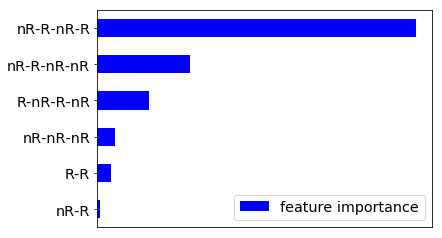

In [10]:
fig, ax = plt.subplots()
df.plot(kind='barh', color='blue', ax=ax, grid=False)
ax.legend(loc='lower right')
# ax.set_xlabel('amplitude')
plt.xticks([])
plt.savefig('../pictures/feature_importance.png')
plt.show()

# Climatic dataset (3 years)

In [2]:
targets_dico = pickle.load(open('../data/clim_labels.obj', 'rb'))
y = list(targets_dico.values())

### 3-hourly 

In [3]:
reload(utils_crops)
input1 = pickle.load(open('../data/clim_bags_1.obj', 'rb'))
input2 = pickle.load(open('../data/clim_bags_2.obj', 'rb'))
X = input1 + input2

In [4]:
# possibly subsample the data
subsamping_rate = 0 # fraction of observations to drop
X = utils_crops.subsample(X,subsamping_rate)

###  daily averages

In [8]:
# X = pickle.load(open('crops/clim_summary_bags.obj', 'rb'))

In [4]:
reload(utils_crops)

<module 'utils_crops' from '../src/utils_crops.py'>

**Fit the models**

In [32]:
reload(RBF_RBF)

<module 'RBF_RBF' from '../src/RBF_RBF.py'>

In [34]:
RBF_RBF.model(X=X, y=y, ll=None, at=False, mode='krr', NUM_TRIALS=5,  cv=3)

In [35]:
reload(kerES)

<module 'kerES' from '../src/kerES.py'>

In [39]:
kerES.model(X, y, depths=[2,3,4],ll=[0], at=True, mode='krr', NUM_TRIALS=5,  cv=3)

 20%|██        | 1/5 [00:33<02:14, 33.57s/it]

best truncation level:  4


 40%|████      | 2/5 [01:07<01:40, 33.66s/it]

best truncation level:  4


 60%|██████    | 3/5 [01:41<01:07, 33.73s/it]

best truncation level:  4


 80%|████████  | 4/5 [02:15<00:33, 33.79s/it]

best truncation level:  4


100%|██████████| 5/5 [02:48<00:00, 33.66s/it]

best truncation level:  4


(0.4775907537095049, 0.12958888726848877)

In [5]:
reload(linSES)

<module 'linSES' from '../src/linSES.py'>

In [2]:
linSES.model(X, y, depths1=[3], depth2=2, ll=[0,1,2], at=True, NUM_TRIALS=5,  cv=3)